# Cell 1: Setup and Installation

In [1]:
!pip install librosa scikit-learn matplotlib numpy pandas noisereduce tensorflow shap

# Cell 1.5

In [2]:
# Cell 1.5: Updated - No unzip needed since files are already extracted
import os
import shutil

# Paths to uploaded files
dataset_path = '/kaggle/input/train-audio'
data_dir = '/kaggle/working/violin-emotion-analysis/data'
csv_path = '/kaggle/input/train-audio/emotion_labels.csv'

# Create the working directory
os.makedirs(data_dir, exist_ok=True)

# Copy all audio files from the dataset to our working directory
audio_source_dir = '/kaggle/input/train-audio/audio'
if os.path.exists(audio_source_dir):
    # Copy all WAV files to our working directory
    for file_name in os.listdir(audio_source_dir):
        if file_name.endswith('.wav'):
            source_path = os.path.join(audio_source_dir, file_name)
            dest_path = os.path.join(data_dir, file_name)
            shutil.copy2(source_path, dest_path)
    
    print(f"Copied audio files to working directory")
else:
    print("Audio folder not found!")

# Check folder structure
print("\nData directory structure:")
for root, dirs, files in os.walk(data_dir):
    level = root.replace(data_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

# Check if CSV exists
if not os.path.exists(csv_path):
    print("\nWARNING: 'emotion_labels.csv' not found!")
else:
    print(f"\nCSV file found: {csv_path}")
    # Also copy CSV to working directory for consistency
    shutil.copy2(csv_path, '/kaggle/working/violin-emotion-analysis/emotion_labels.csv')
    print("CSV copied to working directory")

print(f"\nTotal audio files ready for processing: {len([f for f in os.listdir(data_dir) if f.endswith('.wav')])}")

Copied audio files to working directory

Data directory structure:
data/
  s2.wav
  h3.wav
  h11.wav
  s10.wav
  h23.wav
  s15.wav
  s27.wav
  h15.wav
  s22.wav
  s18.wav
  h1.wav
  a20.wav
  a7.wav
  s4.wav
  a3.wav
  s1.wav
  a15.wav
  s11.wav
  a2.wav
  s17.wav
  h16.wav
  s20.wav
  h13.wav
  a30.wav
  a22.wav
  h4.wav
  a13.wav
  s29.wav
  h24.wav
  a17.wav
  a6.wav
  a1.wav
  s23.wav
  h6.wav
  s16.wav
  h7.wav
  h17.wav
  a12.wav
  h25.wav
  a18.wav
  a9.wav
  s28.wav
  h29.wav
  s7.wav
  h14.wav
  a25.wav
  h20.wav
  s14.wav
  s24.wav
  s30.wav
  s26.wav
  s3.wav
  a24.wav
  h12.wav
  s13.wav
  h2.wav
  h9.wav
  h22.wav
  a11.wav
  a29.wav
  h19.wav
  h21.wav
  a8.wav
  h10.wav
  s6.wav
  a16.wav
  a4.wav
  a19.wav
  h30.wav
  s9.wav
  s19.wav
  a21.wav
  h5.wav
  a14.wav
  a26.wav
  a28.wav
  a23.wav
  h18.wav
  s21.wav
  a5.wav
  h27.wav
  s12.wav
  s5.wav
  a10.wav
  h8.wav
  h28.wav
  h26.wav
  s8.wav
  s25.wav
  a27.wav

CSV file found: /kaggle/input/train-audio/emotion_lab

# Cell 2: Imports and Updated Utility Functions

In [3]:
# ===============================================================
# Cell 2: Imports and Advanced Preprocessing with Noise Handling
# ===============================================================

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Attention, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import noisereduce as nr
import shap
import joblib
import scipy.signal as signal
from tqdm import tqdm
import warnings
import soundfile as sf
warnings.filterwarnings('ignore')

# Create directories
os.makedirs('/kaggle/working/violin-emotion-analysis/data', exist_ok=True)
os.makedirs('/kaggle/working/violin-emotion-analysis/models', exist_ok=True)

# ===============================================================
# 1️⃣ Feature Extraction Helper (Temporal + Cleaned Audio)
# ===============================================================

def extract_temporal_features(file_path, sr=44100, frame_length=2048, hop_length=512, window_size=3.0, hop_time=1.5):
    """
    Extract richer emotion-aware features from violin recordings.
    Captures pitch, tonality, articulation, dynamics, dissonance, and temporal evolution.
    """
    y, sr = librosa.load(file_path, sr=sr)
    y = nr.reduce_noise(y=y, sr=sr)

    total_duration = librosa.get_duration(y=y, sr=sr)
    step = int(hop_time * sr)
    window = int(window_size * sr)

    feature_sequences = []
    for start in range(0, len(y) - window, step):
        segment = y[start:start + window]
        segment_features = []

        # === Core tone features ===
        mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)
        mfccs_delta = librosa.feature.delta(mfccs)
        chroma = librosa.feature.chroma_stft(y=segment, sr=sr)
        chroma_delta = librosa.feature.delta(chroma)
        spectral_contrast = librosa.feature.spectral_contrast(y=segment, sr=sr)

        # === Expression features (temporal dynamics) ===
        rms = librosa.feature.rms(y=segment)  # energy dynamics
        zcr = librosa.feature.zero_crossing_rate(y=segment)  # articulation
        centroid = librosa.feature.spectral_centroid(y=segment, sr=sr)
        bandwidth = librosa.feature.spectral_bandwidth(y=segment, sr=sr)
        flatness = librosa.feature.spectral_flatness(y=segment)
        tempo, _ = librosa.beat.beat_track(y=segment, sr=sr)
        harmony = librosa.feature.tonnetz(y=librosa.effects.harmonic(segment), sr=sr)

        # === Statistical + temporal summarization per segment ===
        # For RMS and ZCR, include their mean, std, and curve (downsampled)
        curve_len = 20  # downsample curve to 20 points
        rms_curve = np.interp(np.linspace(0, rms.shape[1]-1, curve_len), np.arange(rms.shape[1]), rms[0])
        zcr_curve = np.interp(np.linspace(0, zcr.shape[1]-1, curve_len), np.arange(zcr.shape[1]), zcr[0])

        feature_vec = np.hstack([
            np.mean(mfccs, axis=1), np.std(mfccs, axis=1),
            np.mean(mfccs_delta, axis=1), np.std(mfccs_delta, axis=1),
            np.mean(chroma, axis=1), np.mean(chroma_delta, axis=1),
            np.mean(spectral_contrast, axis=1),
            np.mean(centroid), np.std(centroid),
            np.mean(bandwidth),
            np.mean(flatness),
            tempo if not np.isnan(tempo) else 0,
            np.mean(harmony, axis=1),
            np.mean(rms), np.std(rms), rms_curve,  # include RMS curve
            np.mean(zcr), np.std(zcr), zcr_curve   # include ZCR curve
        ])

        feature_sequences.append(feature_vec)

    return np.array(feature_sequences)

# ===============================================================
# 2️⃣ Data Augmentation Helper
# ===============================================================
def augment_audio(y, sr):
    """
    Create slightly altered versions of the same clip to make the model more robust.
    Includes small pitch shifts and speed changes.
    """
    augmented = []

    # Pitch shifts: ±2 semitones
    for n_steps in [-2, 2]:
        augmented.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps))

    # Time stretching using resampling (since librosa.effects.time_stretch expects a spectrogram now)
    for rate in [0.9, 1.1]:
        new_length = int(len(y) / rate)
        augmented.append(librosa.resample(y, orig_sr=sr, target_sr=int(sr * rate))[:new_length])

    return augmented


# ===============================================================
# 3️⃣ Create Temporal Dataset (with Augmented Samples)
# ===============================================================
def create_temporal_dataset(data_dir, emotion_csv_path, augment=True):
    """
    Creates dataset with temporal features and soft emotion labels.
    The CSV must include: filename, emotion, and soft label columns (e.g., happy, sad, angry).
    """
    annotations = pd.read_csv(emotion_csv_path)
    X, y_soft = [], []

    for _, row in tqdm(annotations.iterrows(), total=len(annotations), desc="Creating dataset"):
        file_path = os.path.join(data_dir, row['filename'])
        if not os.path.exists(file_path):
            continue

        # Extract base features
        base_features = extract_temporal_features(file_path)
        X.append(base_features)
        y_soft.append(row[4:].values.astype(float))  # ← soft emotion probabilities
        
        # --- Optional Augmentation ---
        if augment:
            y, sr = librosa.load(file_path, sr=44100)
            y = nr.reduce_noise(y=y, sr=sr)
            y = librosa.util.normalize(y)
            for aug_y in augment_audio(y, sr):
                # Save augmented version's features
                temp_file = "augmented_temp.wav"
                sf.write(temp_file, aug_y, sr)
                aug_features = extract_temporal_features(temp_file)
                X.append(aug_features)
                y_soft.append(row[4:].values.astype(float))
                os.remove(temp_file)

    # Pad sequences for LSTM
    max_len = max(x.shape[0] for x in X)
    num_features = X[0].shape[1]
    X_padded = np.zeros((len(X), max_len, num_features))
    for i, seq in enumerate(X):
        X_padded[i, :seq.shape[0], :] = seq

    return np.array(X_padded), np.array(y_soft)

print("✅ Advanced preprocessing module loaded (with noise reduction, normalization, and augmentation).")

2025-10-23 15:58:25.751252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761235105.966688      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761235106.037936      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Advanced preprocessing module loaded (with noise reduction, normalization, and augmentation).


# Cell 3: Data Preparation

In [ ]:
data_dir = '/kaggle/working/violin-emotion-analysis/data'
emotion_csv_path = '/kaggle/working/violin-emotion-analysis/emotion_labels.csv'  # <-- upload your CSV here

if not os.path.exists(emotion_csv_path):
    print("Please upload 'emotion_labels.csv' with soft emotion probabilities.")
else:
    X, y_soft = create_temporal_dataset(data_dir, emotion_csv_path)
    print(f"Loaded {X.shape[0]} samples with {X.shape[2]} features each and {y_soft.shape[1]} soft emotion dimensions.")

Creating dataset:  69%|██████▉   | 62/90 [22:12<09:05, 19.49s/it] 

# Cell 4: Model Training (LSTM + Random Forest)

Training set: 360 samples
Test set: 90 samples
Emotion dimensions: 3
Training LSTM model with temporal and soft label support...
Epoch 1/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5424 - loss: 0.9749 - val_accuracy: 0.5333 - val_loss: 1.0272 - learning_rate: 0.0010
Epoch 2/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9294 - loss: 0.2424 - val_accuracy: 0.5111 - val_loss: 0.9944 - learning_rate: 0.0010
Epoch 3/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9452 - loss: 0.1566 - val_accuracy: 0.5111 - val_loss: 0.9826 - learning_rate: 0.0010
Epoch 4/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9828 - loss: 0.0886 - val_accuracy: 0.5444 - val_loss: 0.9792 - learning_rate: 0.0010
Epoch 5/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9771 - loss: 0.0965 - val_accuracy: 0.5556 - val_loss: 1.0044 - learning_rate: 0.0010
Epoch 6/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9788 - loss: 0.0644 - val_accuracy: 0.5556 - val_lo

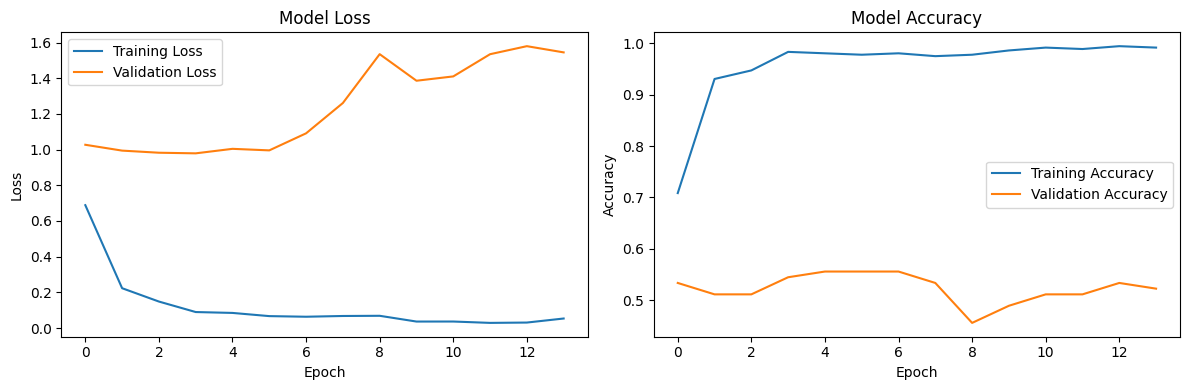

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, LayerNormalization, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import numpy as np

def build_hybrid_model(input_shape, output_dim):
    """
    Hybrid model: Bidirectional LSTM for temporal emotion cues
    + Random Forest for interpretability and ensemble robustness.
    """
    # --- LSTM Branch (Temporal Learning) ---
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64))(x)
    x = Dropout(0.3)(x)
    lstm_output = Dense(64, activation='relu')(x)

    # --- Output for fusion ---
    out = Dense(output_dim, activation='softmax', name="lstm_output")(lstm_output)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# --- Prepare data ---
X_train, X_test, y_train, y_test = train_test_split(X, y_soft, test_size=0.2, random_state=42)

# --- Build and train LSTM ---
input_shape = (X_train.shape[1], X_train.shape[2])
output_dim = y_train.shape[1]

lstm_model = build_hybrid_model(input_shape, output_dim)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# --- Extract embeddings from the LSTM layer before softmax ---
embedding_model = Model(inputs=lstm_model.input,
                        outputs=lstm_model.get_layer("lstm_output").output)

train_embeddings = embedding_model.predict(X_train)
test_embeddings = embedding_model.predict(X_test)

# --- Random Forest for interpretability ---
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(train_embeddings, y_train)

# --- Weighted fusion of predictions ---
lstm_preds = lstm_model.predict(X_test)
rf_preds = rf_model.predict(test_embeddings)
fused_preds = 0.7 * lstm_preds + 0.3 * rf_preds

# --- Evaluate ---
r2 = r2_score(y_test, fused_preds)
print(f"Hybrid Model R² Score: {r2:.4f}")

# Cell 5: Explainability and Visualization

In [ ]:
# Cell 5: Enhanced SHAP Analysis with Emotion-Specific Features
print("🎵 SHAP Analysis - Feature Importance by Emotion")

# Get emotion labels from your CSV
emotion_labels = ['Happy', 'Sad', 'Angry']

# Create SHAP explainer
explainer = shap.Explainer(rf_model, X_train_flat[:100])  # Use first 100 training samples
shap_values = explainer(X_test_flat[:50])

print("🔍 Analyzing feature importance for each emotion...")

# Create separate plots for each emotion
for emotion_idx, emotion_name in enumerate(emotion_labels):
    print(f"\n🎻 {emotion_name.upper()} EMOTION:")
    print("="*40)
    
    # Get SHAP values for this specific emotion
    emotion_shap_values = shap_values.values[:, :, emotion_idx]
    
    # Get top 10 most important features for this emotion
    feature_importance = np.mean(np.abs(emotion_shap_values), axis=0)
    top_feature_indices = np.argsort(feature_importance)[-10:][::-1]  # Top 10
    
    print(f"Top features that predict {emotion_name}:")
    for i, idx in enumerate(top_feature_indices):
        importance = feature_importance[idx]
        print(f"  {i+1}. Feature {idx}: {importance:.4f}")
    
    # Create feature names based on what we know about the extraction
    feature_categories = []
    for i in range(60):  # ~60 features now (we added more)
        if i < 26:  # First 26 are MFCCs (13 mean + 13 std)
            if i < 13:
                feature_categories.append(f"MFCC_{i+1}_mean")
            else:
                feature_categories.append(f"MFCC_{i-12}_std")
        elif i < 38:  # Next 12 are Chroma (mean only)
            feature_categories.append(f"Chroma_{i-25}")
        elif i < 45:  # Next 7 are Spectral Contrast
            feature_categories.append(f"Spectral_Contrast_{i-37}")
        elif i == 45:
            feature_categories.append("RMS_energy")
        elif i == 46:
            feature_categories.append("Zero_Crossing_Rate")
        elif i == 47:
            feature_categories.append("Spectral_Centroid")
        elif i == 48:
            feature_categories.append("Spectral_Bandwidth")
        else:
            feature_categories.append(f"Feature_{i}")
    
    print(f"\n📊 Named features for {emotion_name}:")
    for i, idx in enumerate(top_feature_indices[:5]):  # Top 5 with names
        feature_name = feature_categories[idx]
        importance = feature_importance[idx]
        print(f"  {i+1}. {feature_name}: {importance:.4f}")

# Create the main SHAP summary plot
print("\n📈 Generating main SHAP summary plot...")
shap.summary_plot(shap_values, X_test_flat[:50], feature_names=feature_categories, show=False)
plt.title("SHAP Feature Importance - All Emotions")
plt.tight_layout()
plt.show()

# Additional: Force plot for a single prediction to see detailed reasoning
print("\n🔬 Detailed prediction breakdown for first test sample:")
shap.force_plot(explainer.expected_value[0], shap_values.values[0,:,0], X_test_flat[0,:], 
                feature_names=feature_categories, matplotlib=True, show=False)
plt.title(f"Prediction Breakdown: {emotion_labels[np.argmax(y_test_soft[0])]} → {emotion_labels[rf_model.predict(X_test_flat[0:1])[0]]}")
plt.tight_layout()
plt.show()

# Cell 6: Simulation on New Audio Files

In [ ]:
new_audio_dir = '/kaggle/working/violin-emotion-analysis/new_audio'  # put new audios here
emotion_labels = pd.read_csv(emotion_csv_path).columns[3:].tolist()  # same soft labels as training

new_files = [f for f in os.listdir(new_audio_dir) if f.endswith('.wav')]
print(f"Found {len(new_files)} new audio files for prediction.")

for f in new_files:
    path = os.path.join(new_audio_dir, f)
    
    # Extract features
    features = extract_temporal_features(path)
    
    # Pad sequence to match LSTM input
    padded = np.zeros((1, X_train.shape[1], X_train.shape[2]))
    padded[0, :features.shape[0], :] = features
    
    # LSTM prediction
    lstm_probs = lstm_model.predict(padded)
    
    # RF prediction
    rf_probs = rf_model.predict_proba(np.mean(padded, axis=1))
    rf_probs = np.array([np.pad(p, (0, len(emotion_labels) - len(p))) for p in rf_probs])
    
    # Hybrid fusion
    hybrid_probs = 0.6*lstm_probs + 0.4*rf_probs
    
    # Perceptual smoothing
    smoothed = np.convolve(np.mean(hybrid_probs, axis=0), np.ones(3)/3, mode='same')
    
    # Plot results
    plt.figure(figsize=(8, 5))
    plt.bar(emotion_labels, smoothed)
    plt.title(f"Predicted Emotions for {f}")
    plt.ylabel("Probability")
    plt.ylim(0,1)
    plt.show()
    
    # Print prediction
    pred_emotion = emotion_labels[np.argmax(smoothed)]
    print(f"Audio: {f} → Predicted Emotion: {pred_emotion}")
    print("Probability per emotion:")
    for label, prob in zip(emotion_labels, smoothed):
        print(f"  {label}: {prob:.3f}")
    print("\n" + "-"*40 + "\n")

